# Startup Section

In [1]:
from importlib import reload

import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# from cam_class_optimization import CamGeneration
import cam_class_optimization
from cam_class_optimization import CamGeneration

# Define problem parameters. Forces are in Newtons, lengths are in meters.
angle_data = 'data/Knee-angle_Chugo_2006.csv'
stroke = 0.1
sit_angle_deg = 220
offset_angle_deg = 180
target_force_max = 175
target_force_range = 50
target_percentage_max = 32.5
target_percentage_range = 5
target_sitting_max = 40
target_radius_max = 0.0635

In [2]:
def generate_cam(x, plot=False, index=0):
    """ Generates a cam from the given gear ratios, input angles, and scaling.
    """
    gear_ratios = x[: 8]
    input_angles = x[8 : -1]
    scaling = x[-1]

    Cam = CamGeneration(gear_ratios, input_angles, scaling,
                        sit_angle=np.pi/180*sit_angle_deg,
                        offset_angle=np.pi/180*offset_angle_deg)
    pts_inner, pts_outer, radius_max = Cam.calculate_cam_radii(stroke=stroke,
                                                               plot=plot,
                                                               index=index)
    if np.any(np.isnan(pts_inner)) or np.any(np.isinf(pts_inner)):
        return np.inf, np.inf, 0, np.inf
    forces, percentages = Cam.calc_forces_percentages(angle_data,
                                                      torque=False,
                                                      stroke=stroke,
                                                      plot=plot,
                                                      index=index)
    force_max = max(forces)
    if not np.isnan(force_max):
        perc_force_max = percentages[np.where(forces == force_max)[0][0]]
        perc_sitting_ind = np.where(np.round(percentages, 1) == 0)[0][0]
        force_sitting = forces[perc_sitting_ind]
        return radius_max, perc_force_max, force_max, force_sitting
    else:
        return np.inf, np.inf, 0, np.inf

In [3]:
class multi_objective_mechanism_optimization(Problem):
    
    # When intializing get the mechanism structure which is being optimized
    # (not the initial positions as we are trying to find those)
    def __init__(self, target_force_max, target_force_range,
                 target_percentage_max, target_percentage_range, 
                 target_sitting_max, target_radius_max):
        
        # decision variable bounds
        xl = np.ones(17)
        xu = np.ones(17)

        # elements 0-7: input gear ratios
        xl[0 : 8] *= 0.05
        xu[0 : 8] *= 1.5

        # elements 8-15: input cam angles
        # xl[8 : 16] *= 0.01
        # xu[8 : 16] *= 2*np.pi
        xl[8] = 0
        xl[9] = 1*2*np.pi/8
        xl[10] = 2*2*np.pi/8
        xl[11] = 3*2*np.pi/8
        xl[12] = 4*2*np.pi/8
        xl[13] = 5*2*np.pi/8
        xl[14] = 6*2*np.pi/8
        xl[15] = 7*2*np.pi/8
        xu[8] = 1*2*np.pi/8
        xu[9] = 2*2*np.pi/8
        xu[10] = 3*2*np.pi/8
        xu[11] = 4*2*np.pi/8
        xu[12] = 5*2*np.pi/8
        xu[13] = 6*2*np.pi/8
        xu[14] = 7*2*np.pi/8
        xu[15] = 8*2*np.pi/8
        
        # element 16: cam size scaling factor
        xl[16] *= 0.25
        xu[16] *= 2

        super().__init__(n_var = 17, n_obj=4, n_ieq_constr=4, xl=xl, xu=xu,
                         elementwise_evaluation=True)
        
        # Store mechanism information for later 
        self.target_force_max = target_force_max
        self.target_force_range = target_force_range
        self.target_percentage_max = target_percentage_max
        self.target_percentage_range = target_percentage_range
        self.target_sitting_max = target_sitting_max
        self.target_radius_max = target_radius_max
        
    def _evaluate(self, x, out, *args, **kwargs):
        objective_dict = {1:np.zeros(x.shape[0]), 2:np.zeros(x.shape[0]),
                          3:np.zeros(x.shape[0]), 4:np.zeros(x.shape[0])
                          }
        for i, sub_x in enumerate(x):
            radius_max, perc_force_max,force_max, force_sitting = generate_cam(
                                                            sub_x, plot=False)
            objective_dict[1][i] = radius_max
            objective_dict[2][i] = abs(perc_force_max 
                                       - self.target_percentage_max)
            objective_dict[3][i] = abs(force_max - self.target_force_max)
            objective_dict[4][i] = abs(force_sitting)
            
        # Objective function values:
        out["F"] = [objective_dict[1], objective_dict[2],
                    objective_dict[3], objective_dict[4]
                    ]
        # Constraint values:
        out["G"] = [objective_dict[3] - self.target_force_range,
                    objective_dict[2] - self.target_percentage_range,
                    objective_dict[4] - self.target_sitting_max,
                    objective_dict[1] - self.target_radius_max
                    ]

# Optimization

In [4]:
pop_size = 200
generations = 100

# Set up an instance of our problem.
problem = multi_objective_mechanism_optimization(
    target_force_max = 175,
    target_force_range = 50,
    target_percentage_max = 32.5,
    target_percentage_range = 5,
    target_sitting_max = 40,
    target_radius_max = 0.0635,
    )
algorithm = NSGA2(
    pop_size = pop_size,
    n_offsprings = pop_size,
    sampling = FloatRandomSampling(),
    crossover = SBX(prob=0.9, eta=15),
    mutation = PM(eta=20),
    eliminate_duplicates = True,
    )
termination = get_termination("n_gen", generations)
results = minimize(
    problem,
    algorithm,
    termination,
    verbose = True,
    save_history = True,
    seed = 1,
    )
X = results.X # design space values (decision variables)
F = results.F # objective space values


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  4.4490365165 |  3.119889E+02 |             - |             -
     2 |      400 |      1 |  4.4490365165 |  7.463903E+01 |             - |             -
     3 |      600 |      1 |  3.7556666714 |  5.336536E+01 |             - |             -
     4 |      800 |      1 |  3.7556666714 |  3.900880E+01 |             - |             -
     5 |     1000 |      1 |  0.0172883005 |  2.643981E+01 |             - |             -
     6 |     1200 |      1 |  0.0160513993 |  1.687133E+01 |             - |             -
     7 |     1400 |      1 |  0.0108422277 |  1.032519E+01 |             - |             -
     8 |     1600 |      1 |  0.0105485604 |  7.0235368022 |     

In [5]:
""" percent_array = np.zeros_like(X[:,:8])
for i, elem in enumerate(percent_array):
    percent_array[i] = gear_percentages
xl, xu = problem.bounds()

plt.figure(figsize=(7, 5))
colors = ['r','g','b','c','k','m','y','w']
for i in range(8):
    plt.scatter(percent_array[:,i], X[:, i], s=30, facecolors=colors[7-i], edgecolors=colors[i])
plt.xlim(0, 1)
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.xlabel("Stance Percentage")
plt.ylabel("Gear Ratio")
plt.show()

df_dict = {'Size':F[:,0],'ideal_m_f_perc_diff':F[:,1],'ideal_max_force_diff':F[:,2],'sitting_force':F[:,3]}
df = pd.DataFrame(data=df_dict)
fig = px.scatter_3d(df, x='ideal_m_f_perc_diff', y='ideal_max_force_diff', z='sitting_force', color='Size')
fig.show() """

' percent_array = np.zeros_like(X[:,:8])\nfor i, elem in enumerate(percent_array):\n    percent_array[i] = gear_percentages\nxl, xu = problem.bounds()\n\nplt.figure(figsize=(7, 5))\ncolors = [\'r\',\'g\',\'b\',\'c\',\'k\',\'m\',\'y\',\'w\']\nfor i in range(8):\n    plt.scatter(percent_array[:,i], X[:, i], s=30, facecolors=colors[7-i], edgecolors=colors[i])\nplt.xlim(0, 1)\nplt.ylim(xl[1], xu[1])\nplt.title("Design Space")\nplt.xlabel("Stance Percentage")\nplt.ylabel("Gear Ratio")\nplt.show()\n\ndf_dict = {\'Size\':F[:,0],\'ideal_m_f_perc_diff\':F[:,1],\'ideal_max_force_diff\':F[:,2],\'sitting_force\':F[:,3]}\ndf = pd.DataFrame(data=df_dict)\nfig = px.scatter_3d(df, x=\'ideal_m_f_perc_diff\', y=\'ideal_max_force_diff\', z=\'sitting_force\', color=\'Size\')\nfig.show() '

# Visualization

There are 200 results in the pareto front!
New solution! This is index 0!


NameError: name 'os' is not defined

<Figure size 640x480 with 0 Axes>

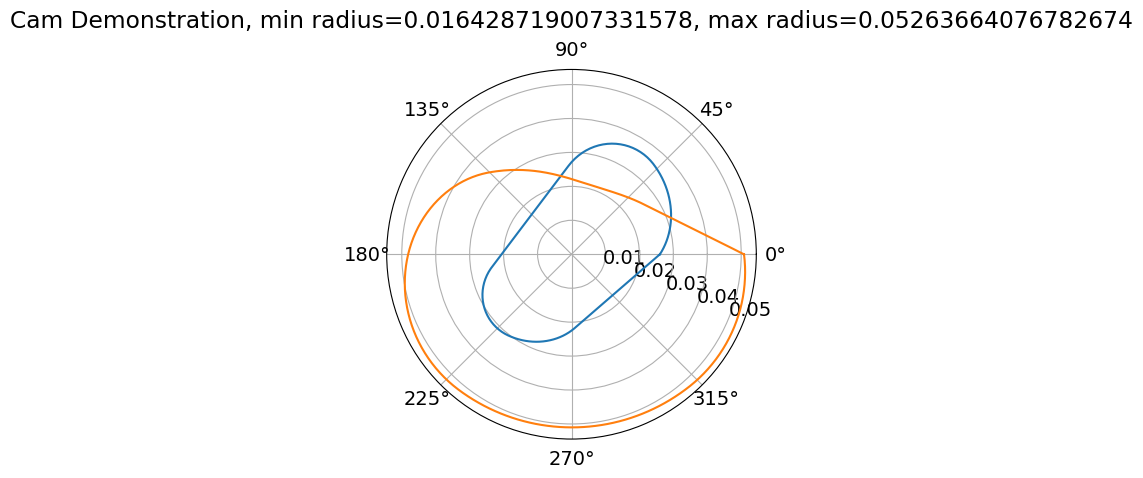

In [7]:
# if len(results.X) <10:
#     print("Less than 10 results!")
#     for sub_x in results.X:
#         gear_ratios = sub_x[:8] # grabs all of the gear ratios except for the last one
#         percentages = sub_x[8:-1] # grabs the gear percentages
#         percentages *= 2 * np.pi
#         initial_gr = sub_x[-1]
#         gear_ratios = np.vstack((gear_ratios,percentages))
#         # percentages = self.percentages
#         # gear_ratios = np.hstack((gear_ratios,self.percentages))
#         # gear_ratios= gear_ratios.reshape((2,-1))
#         # gear_ratios[1,0] = 0
#         # gear_ratios[1, :] = 2 * np.pi * gear_ratios[1, :]
        
#         Cam = CamGeneration(gear_ratios.T, initial_gr, sit_angle = np.pi * 220 / 180) # create Cam object given input gear ratios
#         max_radius = Cam.calculate_cam_radii() # get maximum radius from generated cams
#         filename = 'data/Knee-angle_Chugo_2006.csv'
#         forces,percentages = Cam.plot_forces_percentage(filename, torque = False, stroke = 0.1, plot = False) # get forces from generated cams
# else:

# Reload the cam_class_optimization module to get the latest version of the code.
# (Useful while editing the other file)
reload(cam_class_optimization)
from cam_class_optimization import CamGeneration

print(f'There are {len(X)} results in the pareto front!')
objective_limit = 50
input_array = np.zeros((len(X), 18))
results_array = np.zeros((len(X), 6))
for ind, sub_x in enumerate(X):
    in_range_flag = True
    for res in F[ind]:
        if res > objective_limit:
            in_range_flag = False
    if in_range_flag:
        print(f'New solution! This is index {ind}!')
        radius_max, perc_force_max, force_max, force_sitting = generate_cam(sub_x,
                                                                            plot=True,
                                                                            index=ind)
        error_total = (radius_max
                       + abs(perc_force_max - target_percentage_max)
                       + abs(force_max - target_force_max)
                       + abs(force_sitting)
                       )
        input_array[ind] = np.append([ind], sub_x)
        results_array[ind] = np.array([ind, radius_max, perc_force_max,
                                       force_max, force_sitting, error_total])

        print('max force of', force_max,' at ',perc_force_max, ' %')
        print('max radii = ',radius_max)
        print(f'sitting force = {force_sitting}')
        print(f'Max radius = {F[ind][0]}, max_force_perc - 32.5 = {F[ind][1]}, \
              max_force_diff = {F[ind][2]}, sitting_force = {F[ind][3]}')
        print('TOTAL ERROR = ', error_total)
        print('----------------------------------END----------------------------------')

input_headers = ['Index', 'Gear Ratio 1', 'Gear Ratio 2', 'Gear Ratio 3', \
                 'Gear Ratio 4', 'Gear Ratio 5', 'Gear Ratio 6', 'Gear Ratio 7', \
                 'Gear Ratio 8', 'Percentage 1', 'Percentage 2', 'Percentage 3', \
                 'Percentage 4', 'Percentage 5', 'Percentage 6', 'Percentage 7', \
                 'Percentage 8', 'Initial Gear Ratio'
                 ]
results_headers = ['Index', 'Max Radius', 'Max Force Percentage', 'Max Force', \
                   'Sitting Force', 'Total Error']
np.savetxt('input_array.csv', input_array, fmt='%.2f', delimiter=',',
           header=','.join(input_headers))
np.savetxt('results_array.csv', results_array, fmt='%.2f', delimiter=',',
           header=','.join(results_headers))

In [ ]:
objective_limit = 50
flag_array = np.zeros(np.shape(F[:,0]))
F = np.hstack((F, np.zeros((len(F),1))))
for ind, sub_x in enumerate(F):
        for res in sub_x:
            if res > objective_limit:
                flag_array[ind] = 1
        F[ind,4] = ind
Fvalid = np.delete(F, np.where(flag_array == 1), axis=0)
df_dict = {'Index': Fvalid[:, 4], 'Max Radius': Fvalid[:, 0],
           'Peak Percentage Error': Fvalid[:, 1],
           'Peak Force Error': Fvalid[:, 2], 'Sitting Force': Fvalid[:, 3]}
df = pd.DataFrame(data=df_dict)
fig = px.scatter_3d(df, x='Peak Percentage Error', y='Peak Force Error',
                    z='Sitting Force', color='Max Radius', hover_data=['Index'])
fig.show()